## This is a version of the CNN using RESNET and only four emotes

It does not use the Toungue Out emote as our live demo struggled with Toungue Out. We wanted to make one for live-demo purposes without Toungue Out to see how it performed.

AI/ CNN HW helped us generate this code - we used similar code for each frame based CNN



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/DS340/frames.zip -d /content/

Archive:  /content/drive/MyDrive/DS340/frames.zip
   creating: /content/frames/
  inflating: /content/__MACOSX/._frames  
  inflating: /content/frames/.DS_Store  
  inflating: /content/__MACOSX/frames/._.DS_Store  
   creating: /content/frames/test/
  inflating: /content/__MACOSX/frames/._test  
   creating: /content/frames/original_frames/
  inflating: /content/__MACOSX/frames/._original_frames  
   creating: /content/frames/train/
  inflating: /content/__MACOSX/frames/._train  
   creating: /content/frames/validation/
  inflating: /content/__MACOSX/frames/._validation  
   creating: /content/frames/test/TongueOut/
  inflating: /content/__MACOSX/frames/test/._TongueOut  
   creating: /content/frames/test/HandsUp/
  inflating: /content/__MACOSX/frames/test/._HandsUp  
   creating: /content/frames/test/Cry/
  inflating: /content/__MACOSX/frames/test/._Cry  
   creating: /content/frames/test/Still/
  inflating: /content/__MACOSX/frames/test/._Still  
   creating: /content/frames/test/Yaw

In [3]:
import shutil
from pathlib import Path

DATA_DIR = Path("/content/frames")

for split in ["train", "validation", "test"]:
    tong_path = DATA_DIR / split / "TongueOut"
    if tong_path.exists():
        print("Removing:", tong_path)
        shutil.rmtree(tong_path)

print("Remaining train classes:", [p.name for p in (DATA_DIR / "train").iterdir()])
print("Remaining val classes:", [p.name for p in (DATA_DIR / "validation").iterdir()])
print("Remaining test classes:", [p.name for p in (DATA_DIR / "test").iterdir()])

Removing: /content/frames/train/TongueOut
Removing: /content/frames/validation/TongueOut
Removing: /content/frames/test/TongueOut
Remaining train classes: ['Still', 'Cry', 'Yawn', 'HandsUp']
Remaining val classes: ['Still', 'Cry', 'Yawn', 'HandsUp']
Remaining test classes: ['Still', 'Cry', 'Yawn', 'HandsUp']


In [4]:
import os
from pathlib import Path
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

print("PyTorch:", torch.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


PyTorch: 2.9.0+cu126
Using device: cuda


In [15]:
BATCH_SIZE = 32
NUM_CLASSES = 4
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder(DATA_DIR/"train", transform=train_transform)
val_dataset   = datasets.ImageFolder(DATA_DIR/"validation", transform=val_test_transform)
test_dataset  = datasets.ImageFolder(DATA_DIR/"test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

idx_to_class = {v:k for k,v in train_dataset.class_to_idx.items()}
print("idx_to_class:", idx_to_class)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))


idx_to_class: {0: 'Cry', 1: 'HandsUp', 2: 'Still', 3: 'Yawn'}
Train size: 476
Val size: 100
Test size: 112


In [16]:
from torchvision import models


model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Model ready.")


Model ready.


In [17]:
def train_one_epoch(epoch, model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    running_correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total

    print(f"Epoch {epoch} TRAIN Loss={epoch_loss:.4f} Acc={epoch_acc:.4f}")
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device, name="VAL"):
    model.eval()
    running_loss = 0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * imgs.size(0)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    print(f"{name}: Loss={epoch_loss:.4f} Acc={epoch_acc:.4f}")
    return epoch_loss, epoch_acc


In [19]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

In [20]:
NUM_EPOCHS = 10
best_val_acc = 0.0
best_model_path = "/content/best_resnet18_emotes_no_tongue.pth"
PATIENCE = 3
epochs_without_improvement = 0

for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc     = evaluate(model, val_loader, criterion, DEVICE, "VAL")

    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved best model (val={best_val_acc:.4f})")
    else:
        epochs_without_improvement += 1
    if epochs_without_improvement >= PATIENCE:
        print(f"Early stopping triggered at epoch {epoch}.")
        break



Epoch 1 TRAIN Loss=0.2098 Acc=0.9370
VAL: Loss=0.2600 Acc=0.9000
Saved best model (val=0.9000)
Epoch 2 TRAIN Loss=0.1166 Acc=0.9664
VAL: Loss=0.3086 Acc=0.9100
Saved best model (val=0.9100)
Epoch 3 TRAIN Loss=0.0661 Acc=0.9832
VAL: Loss=0.1964 Acc=0.9100
Epoch 4 TRAIN Loss=0.0814 Acc=0.9832
VAL: Loss=0.2197 Acc=0.9200
Saved best model (val=0.9200)
Epoch 5 TRAIN Loss=0.0464 Acc=0.9874
VAL: Loss=0.1187 Acc=0.9500
Saved best model (val=0.9500)
Epoch 6 TRAIN Loss=0.0361 Acc=0.9916
VAL: Loss=0.0739 Acc=0.9600
Saved best model (val=0.9600)
Epoch 7 TRAIN Loss=0.0463 Acc=0.9874
VAL: Loss=0.1069 Acc=0.9500
Epoch 8 TRAIN Loss=0.0410 Acc=0.9874
VAL: Loss=0.0873 Acc=0.9800
Saved best model (val=0.9800)
Epoch 9 TRAIN Loss=0.0522 Acc=0.9853
VAL: Loss=0.1271 Acc=0.9600
Epoch 10 TRAIN Loss=0.0392 Acc=0.9895
VAL: Loss=0.0994 Acc=0.9600


In [21]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
print("Loaded best model.")

test_acc = evaluate(model, test_loader, criterion, DEVICE, "TEST")
print("Final TEST accuracy:", test_acc)


Loaded best model.
TEST: Loss=0.0981 Acc=0.9821
Final TEST accuracy: (0.09810811653733253, 0.9821428571428571)


In [ ]:
drive_path = "/content/drive/MyDrive/DS340/best_resnet18_emotes_no_tongue.pth"
!cp "/content/best_resnet18_emotes_no_tongue.pth" "$drive_path"
print("Model saved to:", drive_path)


Model saved to: /content/drive/MyDrive/DS340/best_resnet18_emotes_no_tongue.pth


## Graphs

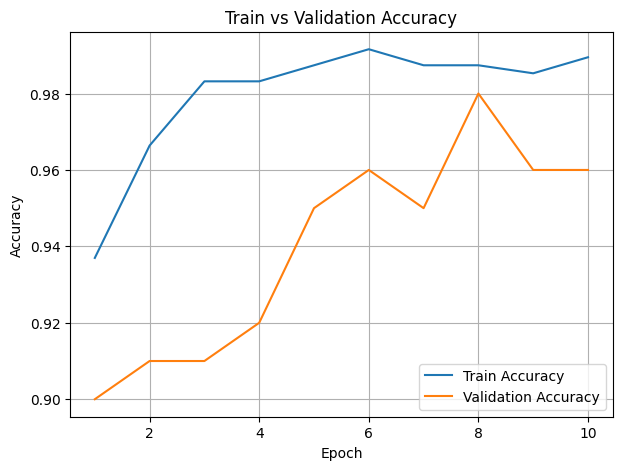

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc_history) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
import numpy as np
import torch.nn.functional as F

all_labels = []
all_preds  = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

print("Labels shape:", all_labels.shape)
print("Preds shape:", all_preds.shape)


Labels shape: (112,)
Preds shape: (112,)


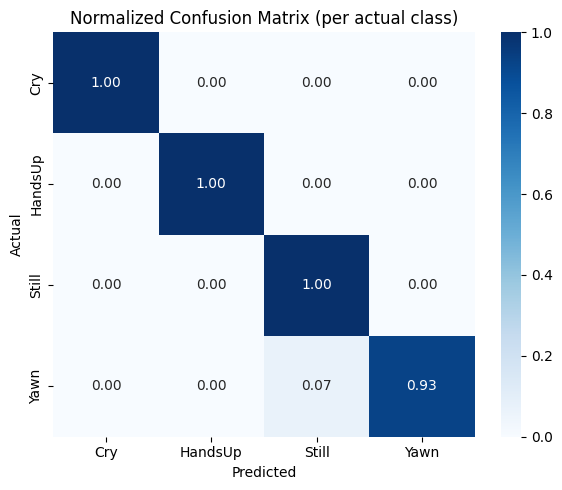

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


labels_list = list(range(NUM_CLASSES))


cm = confusion_matrix(all_labels, all_preds, labels=labels_list)


cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

class_names = [idx_to_class[i] for i in labels_list]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (per actual class)")
plt.tight_layout()
plt.show()